In [90]:
import cv2
import numpy as np
import matplotlib.pyplot  as plt
import tensorflow as tf
from tensorflow.keras import layers

def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)


def init_models():
    print(f"Tensorflow Version: {tf.__version__}")
    # read pre-trained model and config file
    net = cv2.dnn.readNet('config/yolov3.weights', "config/yolov3.cfg")
    # Load Goose Detection model
    model = tf.keras.models.load_model('config/goose_model')
    model.summary()
    return (net, model)


def get_yolo_boxes(net, image):
    height, width, _ = image.shape
    scale = 0.00392

    # create input blob 
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)
    # set input blob for the network
    net.setInput(blob)

    # run inference through the network
    # and gather predictions from output layers
    outs = net.forward(get_output_layers(net))
    # initialization
    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    # for each detetion from each output layer 
    # get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
    # apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    return (indices, class_ids, boxes, confidences)


# function to get the output layer names in the architecture
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers


def get_goose_pred(model, subimage):
    resized_img = cv2.resize(subimage, (180, 180), interpolation = cv2.INTER_AREA)

    modelinput = tf.expand_dims(resized_img, axis=0)
    prediction = model.predict(modelinput)[0]
    print(f"Activations: {prediction}")
    return np.argmax(prediction)


def get_goose_boxes(models, image):
    indices, class_ids, boxes, confidences = get_yolo_boxes(models[0], image.copy())
    print(boxes)
    # Create Subimages
    subimages = []
    result = []
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = clamp(round(box[0]), 0, image.shape[0])
        y = clamp(round(box[1]), 0, image.shape[1])
        w = round(box[2])
        h = round(box[3])
        print(f"({x}, {y}, {w}, {h}) = {class_ids[i]}")
#         plt.imshow(image[round(y):round(y+h), round(x):round(x+w)])
#         plt.show()
#         draw_goose_bounding_box(image, x, y, x+w, y+h)
        if class_ids[i] == 14:
            # Is a bird
            subimg = (image[y:y+h, x:x+w])
            if get_goose_pred(models[1], subimg) == 0:
                # Is a goose
                result.append( (x,y,w,h) )
#         plt.imshow(image)
#         plt.show()
    return result


def draw_goose_bounding_box(img, x, y, x_plus_w, y_plus_h):
    color = (255,0,0)
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, "Goose", (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [88]:
models = init_models()

Tensorflow Version: 2.3.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (

[[317.5, 32.0, 179, 198], [136.5, 102.0, 513, 240]]
(318, 32, 179, 198) = 15
(136, 102, 513, 240) = 14


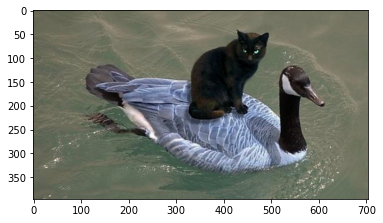

Activations: [ 1.6160661 -5.0434713]


[(136, 102, 513, 240)]

In [95]:
# read input image
image = cv2.imread('./Images/Goose & Cat.jpg')
plt.imshow(image)
get_goose_boxes(models, image)